<a href="https://colab.research.google.com/github/INT2-Group3-2023/int_assessment/blob/main/resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [2]:
data, ds_info = tfds.load('oxford_flowers102',
                         with_info=True,
                          as_supervised=True,
                          shuffle_files = True)
train_ds, valid_ds, test_ds = data['train'], data['validation'], data['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete6Y1D7S/oxford_flowers102-train.tfrecord*…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete6Y1D7S/oxford_flowers102-test.tfrecord*.…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incomplete6Y1D7S/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [3]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [4]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [5]:
def scale_resize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # equivalent to dividing image pixels by 255
    image = tf.image.resize(image, (224, 224)) # Resizing the image to 224x224 dimention
    return (image, label)

In [6]:
def rgb_convert(image, label):
    image = tf.image.rgb_to_grayscale(image)
    return (image, label)

In [7]:
def crop_image(image, label):
    image = tf.image.resize_with_crop_or_pad(image, 500, 500)
    return (image, label)

In [8]:
def resize_with_crop_or_pad(image, label):
    image = tf.image.resize_with_crop_or_pad(image, 752, 752)
    return (image, label)

In [9]:
AUTO = tf.data.experimental.AUTOTUNE
CLASS_TYPES = ds_info.features['label'].num_classes
BATCH_SIZE = 64

In [10]:
training_ds = (train_ds.map(crop_image))
training_ds = (training_ds.map(scale_resize_image))
#training_ds = (training_ds.map(rgb_convert))
#training_ds = train_ds.map(resize_with_crop_or_pad)
training_ds = training_ds.batch(BATCH_SIZE)

In [11]:
testing_ds = (test_ds.map(crop_image))
testing_ds = (testing_ds.map(scale_resize_image))
#testing_ds = testing_ds.map(rgb_convert)
#testing_ds = test_ds.map(resize_with_crop_or_pad)
testing_ds = testing_ds.batch(BATCH_SIZE)

In [12]:
validation_ds = (valid_ds.map(crop_image))
validation_ds = (validation_ds.map(scale_resize_image))
validation_ds = validation_ds.batch(BATCH_SIZE)

In [13]:
counter = 0
for example in train_ds:
  counter = counter + 1
print(counter)

1020


In [14]:
def visualise(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title("original")
    plt.imshow(original)

    plt.subplot(1,2,2)
    plt.title("augmented")
    plt.imshow(augmented)

In [15]:
def show_augmentations():
    image, label = next(iter(train_ds))
    # line of augmentation
    augmented = tf.image.adjust_contrast(image, 2)
    visualise(image, augmented)
    plt.show()

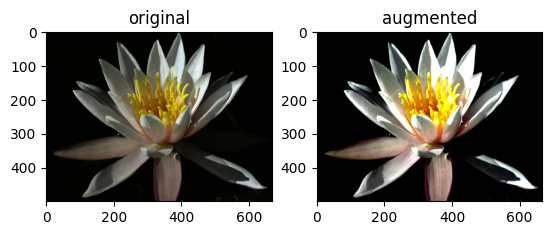

In [16]:
show_augmentations()

In [27]:
# EXCITING BLOCK OF COMMENTS
# first resent takes the image and does preprocessing augmentation etc
# then it does a conv2d layer
# then a 2x2 pool 
# then we get into the bulk of it
# its basically four blocks, each with a different combination of conv and identity layers
# then another 2x2 pool
# and then finally it pushes it into a fully connected layer which is used to make the predictions
# lots of layers basically 

In [17]:
#THIS IS DEFINING THE FIRST BLOCK: cfg0
# one conv layer and 2 identity layers
# kernel constraint makes sure weights are normalised
cfg0_conv_input = keras.Input(shape=(56,56,64), name='cfg0_conv')
x = keras.layers.Conv2D(64, kernel_size=1, strides=1, activation='relu', padding='valid', kernel_constraint=keras.constraints.max_norm(2.)) (cfg0_conv_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, kernel_size=3, strides=1, activation='relu', padding='same', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)


# defining the conv layer
cfg0_conv_input_transform = keras.layers.Conv2D(256, kernel_size=1, strides=1, activation='relu', padding='same', kernel_constraint=keras.constraints.max_norm(2.)) (cfg0_conv_input)
cfg0_conv_input_op = keras.layers.BatchNormalization()(cfg0_conv_input_transform)
x = keras.layers.Add()([x, cfg0_conv_input_op])
cfg0_conv_output = keras.layers.ReLU()(x)

# its called cfg0_conv, itll get used when defining this block
cfg0_conv = keras.Model(inputs=cfg0_conv_input, outputs=cfg0_conv_output, name='cfg0_conv')




#defining the identity layer
cfg0_identity_input = keras.Input(shape=(56, 56, 256), name='cfg0_identity')
x = keras.layers.Conv2D(64, kernel_size=1, strides=1, padding='valid', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (cfg0_identity_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Add()([x, cfg0_identity_input])
cfg0_identity_output = keras.layers.ReLU()(x)

# cfg0_identity is the name
cfg0_identity = keras.Model(inputs=cfg0_identity_input, outputs=cfg0_identity_output, name='cfg0_identity_p1')




cfg0_input = keras.Input(shape=(56, 56, 64), name='cfg0')
# conv layer we defined earlier
x = cfg0_conv(cfg0_input)
# and the identity layers
x = cfg0_identity(x)
# this is the second one, used to crate the output for the block, cfg0_output
cfg0_output = cfg0_identity(x)

# finally defining the entire block
# the block gets used later on in a function build_resnet_model
# which puts loads of these blocks together into the what is the resnet architecture
# they get more convoluted as they go on which is why the code is modular like this
cfg0 = keras.Model(inputs=cfg0_input, outputs=cfg0_output, name='cfg0_block')

# output shape (56,56,256)


In [18]:
# THIS IS DEFINING THE SECOND BLOCK: cfg1
# pretty similar
# 1 conv layer, 2 identity layers
# this block has more out_channels
cfg1_conv_input = keras.Input(shape=(56, 56, 256), name='cfg1_conv')
x = keras.layers.Conv2D(128, kernel_size=1, strides=2, activation='relu', padding='valid', kernel_constraint=keras.constraints.max_norm(2.)) (cfg1_conv_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, kernel_size=3, strides=1, activation='relu', padding='same', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(512, kernel_size=1, strides=1, padding='valid', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)

#defining the conv layer
cfg1_conv_input_transform = keras.layers.Conv2D(512, kernel_size=1, strides=2, activation='relu', padding='same', kernel_constraint=keras.constraints.max_norm(2.)) (cfg1_conv_input)
cfg1_conv_input_output = keras.layers.BatchNormalization()(cfg1_conv_input_transform)
x = keras.layers.Add()([x, cfg1_conv_input_output])
cfg1_conv_output = keras.layers.ReLU()(x)

# its called cfg1_conv used a bit later in this block
cfg1_conv = keras.Model(inputs=cfg1_conv_input, outputs=cfg1_conv_output, name='cfg1_conv')




# defining the identity layer
cfg1_identity_input = keras.Input(shape=(28, 28, 512), name='cfg1_identity')
x = keras.layers.Conv2D(128, kernel_size=1, strides=1, padding='valid', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (cfg1_identity_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(512, kernel_size=1, strides=1, padding='valid', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Add()([x, cfg1_identity_input])
cfg1_identity_output = keras.layers.ReLU()(x)

# here it is its called cfg1_identity
cfg1_identity = keras.Model(inputs=cfg1_identity_input, outputs=cfg1_identity_output, name='cfg1_identity_p1')


cfg1_input = keras.Input(shape=(56, 56, 256), name='cfg1')
# the conv layer
x = cfg1_conv(cfg1_input)
# the 2 identity layers
# i think they did it like this for readability
x = cfg1_identity(x)
x = cfg1_identity(x)
cfg1_output = cfg1_identity(x)

# finally defining the entire block which gets used later in build_resnet_model
cfg1 = keras.Model(inputs=cfg1_input, outputs=cfg1_output, name='cfg1_block')

# output shape : (28,28,512)

In [19]:
# THIS IS DEFINING THE 3RD BLOCK: cfg2
# 1 conv layer 5 identity layers
cfg2_conv_input = keras.Input(shape=(28, 28, 512), name='cfg2_conv')
x = keras.layers.Conv2D(256, kernel_size=1, strides=2, activation='relu', padding='valid', kernel_constraint=keras.constraints.max_norm(2.)) (cfg2_conv_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256, kernel_size=3, strides=1, activation='relu', padding='same', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(1024, kernel_size=1, strides=1, padding='valid', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)

# defining the conv layer
# cfg2_conv
cfg2_conv_input_transform = keras.layers.Conv2D(1024, kernel_size=1, strides=2, activation='relu', padding='same', kernel_constraint=keras.constraints.max_norm(2.)) (cfg2_conv_input)
cfg2_conv_input_output = keras.layers.BatchNormalization()(cfg2_conv_input_transform)
x = keras.layers.Add()([x, cfg2_conv_input_output])
cfg2_conv_output = keras.layers.ReLU()(x)

cfg2_conv = keras.Model(inputs=cfg2_conv_input, outputs=cfg2_conv_output, name='cfg2_conv')




cfg2_identity_input = keras.Input(shape=(14, 14, 1024), name='cfg2_identity')
x = keras.layers.Conv2D(256, kernel_size=1, strides=1, padding='valid', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (cfg2_identity_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(1024, kernel_size=1, strides=1, padding='valid', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)

#defining identity layer
# cfg2_identity
# saves the repetition etc
x = keras.layers.Add()([x, cfg2_identity_input])
cfg2_identity_output = keras.layers.ReLU()(x)
cfg2_identity = keras.Model(inputs=cfg2_identity_input, outputs=cfg2_identity_output, name='cfg2_identity_p1')

# defining the whole block
cfg2_input = keras.Input(shape=(28, 28, 512), name='cfg2')
# the identity layer
x = cfg2_conv(cfg2_input)
# 5 identity layers
x = cfg2_identity(x)
x = cfg2_identity(x)
x = cfg2_identity(x)
x = cfg2_identity(x)
cfg2_output = cfg2_identity(x)

# instantiating the variable used in build_resnet_model later on
cfg2 = keras.Model(inputs=cfg2_input, outputs=cfg2_output, name='cfg2_block')

# output shape (14,14,1024)

In [20]:
#THIS IS DEFINING THE FOURTH AND FINAL :) BLOCK: cfg3
# 1 conv layer
# 2 identity layers
cfg3_conv_input = keras.Input(shape=(14, 14, 1024), name='cfg3_conv')
x = keras.layers.Conv2D(512, kernel_size=1, strides=2, activation='relu', padding='valid', kernel_constraint=keras.constraints.max_norm(2.)) (cfg3_conv_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(512, kernel_size=3, strides=1, activation='relu', padding='same', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(2048, kernel_size=1, strides=1, padding='valid', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)

cfg3_conv_input_transform = keras.layers.Conv2D(2048, kernel_size=1, strides=2, activation='relu', padding='same', kernel_constraint=keras.constraints.max_norm(2.)) (cfg3_conv_input)
cfg3_conv_input_output = keras.layers.BatchNormalization()(cfg3_conv_input_transform)
x = keras.layers.Add()([x, cfg3_conv_input_output])
cfg3_conv_output = keras.layers.ReLU()(x)

cfg3_conv = keras.Model(inputs=cfg3_conv_input, outputs=cfg3_conv_output, name='cfg3_conv')



# defining the identity layer
#cfg3_identity
cfg3_identity_input = keras.Input(shape=(7, 7, 2048), name='cfg3_identity')
x = keras.layers.Conv2D(512, kernel_size=1, strides=1, padding='valid', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (cfg3_identity_input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(512, kernel_size=3, strides=1, padding='same', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(2048, kernel_size=1, strides=1, padding='valid', activation='relu', kernel_constraint=keras.constraints.max_norm(2.)) (x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Add()([x, cfg3_identity_input])
cfg3_identity_output = keras.layers.ReLU()(x)

# final def here:
cfg3_identity = keras.Model(inputs=cfg3_identity_input, outputs=cfg3_identity_output, name='cfg3_identity_p1')

# defining the acc block
cfg3_input = keras.Input(shape=(14, 14, 1024), name='cfg3')
x = cfg3_conv(cfg3_input)
x = cfg3_identity(x)
cfg3_output = cfg3_identity(x)

# final declaration for the variable name cfg3 (the block)
# used in build_resnet_model
cfg3 = keras.Model(inputs=cfg3_input, outputs=cfg3_output, name='cfg3_block')

# ouput shape: (7,7,2048)

In [21]:
# finally something different
# contains average pooling layer
# drop out layer
# flatten layer
classifier_input = keras.Input(shape=(7, 7, 2048), name='classifier')
#average pooling
x = keras.layers.AveragePooling2D(pool_size=2, padding='same')(classifier_input)
# dropout
x = keras.layers.Dropout(0.2)(x)
# flatten 
x = keras.layers.Flatten()(x)
# pushed into a fully connected layer which produces the predictions
# softmax is used to generate the probabilities
classifier_output = keras.layers.Dense(CLASS_TYPES, activation='softmax', kernel_constraint=keras.constraints.max_norm(2.))(x)

classifier = keras.Model(inputs=classifier_input, outputs=classifier_output, name='classifier')

# output shape: (1,CLASS_TYPES) 
# btw class_types is a new variable defined a bit further up next to batch size

In [22]:
# split up some of the layers for better readability 
# these are just our standard augementation layers no changes
augmentationLayers = keras.Sequential([
    # augmentation 
    #keras.layers.CenterCrop(500, 500),
    #keras.layers.Resizing(128, 128), 
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(1),
    keras.layers.RandomZoom(0.5),
    #keras.layers.RandomContrast((0, 1)),
    keras.layers.RandomBrightness(0.2/255),
    keras.layers.RandomTranslation(0.1, 0.1),    
    keras.layers.BatchNormalization(),#standardise raw 0-1 input
    

])

In [23]:
# this is the mythical build_resnet_function ive been going on about in the comments
def build_resnet_model():
    resnet_input = keras.Input(shape=(224, 224, 3), name='input')
    # applying our augementations
    x = augmentationLayers(resnet_input)
    # the first conv layer
    x = keras.layers.Conv2D(64, kernel_size=7, activation='relu', padding='same', strides=2, kernel_constraint=keras.constraints.max_norm(2.))(x)
    # and the 2x2 pool
    conv1_output = keras.layers.MaxPooling2D(pool_size=3, padding='same', strides=2) (x)
    # applying the blocks starting with cfg0 on the output from the pool
    x = cfg0(conv1_output)
    x = cfg1(x)
    x = cfg2(x)
    x = cfg3(x)
    # then applying the classifier
    model_output = classifier(x)
    resnet_model = keras.Model(inputs=resnet_input, outputs=model_output, name='resnet50')

    # this is pretty cool to illustrate the architecture
    print(resnet_model.summary())

    # standard issue compiling the model, although i did it again later in another block of code 
    resnet_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    
    # finally free from the resnet model
    return resnet_model

In [24]:
# finally creating the model via the function
# peep the model summary
model = build_resnet_model()

Model: "resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       12        
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 cfg0_block (Functional)     (None, 56, 56, 256)       148480    
                                                                 
 cfg1_block (Functional)     (None, 28, 28, 512)       665600    
                                                          

In [25]:
# do it. again.
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = ["accuracy"]
)

In [26]:
# i didnt implement the plateau function or any of the callbacks yet bc i just wanted to get this working
# after training i got 22% test accuracy 
model.fit(training_ds, epochs = 200, verbose=2)
model.evaluate(testing_ds)

Epoch 1/200
16/16 - 51s - loss: 40.5021 - accuracy: 0.0069 - 51s/epoch - 3s/step
Epoch 2/200
16/16 - 12s - loss: 22.6752 - accuracy: 0.0069 - 12s/epoch - 778ms/step
Epoch 3/200
16/16 - 13s - loss: 14.7145 - accuracy: 0.0118 - 13s/epoch - 788ms/step
Epoch 4/200
16/16 - 13s - loss: 13.1368 - accuracy: 0.0078 - 13s/epoch - 784ms/step
Epoch 5/200
16/16 - 12s - loss: 10.6073 - accuracy: 0.0245 - 12s/epoch - 777ms/step
Epoch 6/200
16/16 - 12s - loss: 14.1084 - accuracy: 0.0167 - 12s/epoch - 762ms/step
Epoch 7/200
16/16 - 12s - loss: 10.7293 - accuracy: 0.0245 - 12s/epoch - 769ms/step
Epoch 8/200
16/16 - 12s - loss: 12.3836 - accuracy: 0.0275 - 12s/epoch - 775ms/step
Epoch 9/200
16/16 - 12s - loss: 9.9165 - accuracy: 0.0196 - 12s/epoch - 771ms/step
Epoch 10/200
16/16 - 12s - loss: 9.8198 - accuracy: 0.0284 - 12s/epoch - 767ms/step
Epoch 11/200
16/16 - 12s - loss: 9.8562 - accuracy: 0.0225 - 12s/epoch - 769ms/step
Epoch 12/200
16/16 - 12s - loss: 10.4302 - accuracy: 0.0245 - 12s/epoch - 771ms/

[4.318483352661133, 0.22280044853687286]

In [ ]:
# lastly as a note i basically ripped off this website :
# https://towardsdatascience.com/the-annotated-resnet-50-a6c536034758
# i just integrated their example with our code and added the comments to make the different layers a bit more obvious
# it was good to work through to really understand the architecture
# but this is a good starting point to alter some of the blocks, particularly cfg2
# and implement whatever else 
# im done now 
# i just get a bit addicted to writing comments sometimes
# last one